# Book Recommendation System using Neural Networks

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")
from data.data_helper_functions import *

## Load the data

In [2]:
data_path = "../data/"

In [3]:
books_df, users_df, ratings_df = load_data(data_path)

In [48]:
# train_ratings_df, test_ratings_df = train_test_split(ratings_df, test_size=0.2, random_state=0)

train_ratings_df, test_ratings_df = split_ratings_by_user(ratings_df, test_size = 0.2, random_state=0)

In [49]:
# Because we removed users with not enough ratings: less than 4
# To them, the popular books would be recommended 
user_id_mapping = {user_id: i for i, user_id in enumerate(users_df.index.unique())}
train_ratings_df["user_id"] = train_ratings_df["user_id"].map(user_id_mapping)
test_ratings_df["user_id"] = test_ratings_df["user_id"].map(user_id_mapping)

## Build the model

In [50]:
# Creating book embedding
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(len(books_df) + 1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# Create user embedding
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(len(users_df) + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Concatenate features
concatenated = Concatenate()([book_vec, user_vec])

# Add fully-connected layers
fc1 = Dense(128, activation="relu")(concatenated)
fc2 = Dense(32, activation="relu")(fc1)
out = Dense(1)(fc2)

# Create the model and compile it
model = Model([user_input, book_input], out)
model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])

In [54]:
# Train the model
history = model.fit([train_ratings_df.user_id, train_ratings_df.book_id], train_ratings_df.rating, 
                    epochs=3, verbose=True, validation_split=0.2)

Epoch 1/3
18977/18977 [==============================] - 53s 3ms/step - loss: 0.6618 - mean_absolute_error: 0.6262 - val_loss: 0.7109 - val_mean_absolute_error: 0.6462
Epoch 2/3
18977/18977 [==============================] - 58s 3ms/step - loss: 0.6365 - mean_absolute_error: 0.6090 - val_loss: 0.7063 - val_mean_absolute_error: 0.6448
Epoch 3/3
18977/18977 [==============================] - 58s 3ms/step - loss: 0.6137 - mean_absolute_error: 0.5938 - val_loss: 0.7124 - val_mean_absolute_error: 0.6488


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.plot(history.history["loss"], label="Training Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()
plt.show()

In [56]:
# Evaluate the model
mse = model.evaluate([test_ratings_df.user_id, test_ratings_df.book_id], test_ratings_df.rating)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

5931/5931 [==============================] - 7s 1ms/step - loss: 0.7056 - mean_absolute_error: 0.6468
RMSE: [0.83997181 0.80421538]


In [32]:
# Do some predictions
predictions = model.predict([test_ratings_df.user_id.head(10), test_ratings_df.book_id.head(10)])

print("Model prediction vs. Ground truth rating")
for i in range(0, 10):
    pred = round(float(predictions[i][0]), 3)
    print(f"{pred} vs. {test_ratings_df.rating.iloc[i]}")

1/1 [==============================] - 0s 29ms/step
Model prediction vs. Ground truth rating
5.065 vs. 5
3.802 vs. 4
3.545 vs. 3
4.113 vs. 5
3.335 vs. 3
4.056 vs. 3
3.892 vs. 3
4.905 vs. 4
4.204 vs. 3
4.215 vs. 5


## Visualize the embeddings

In [33]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

In [34]:
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

<Axes: >

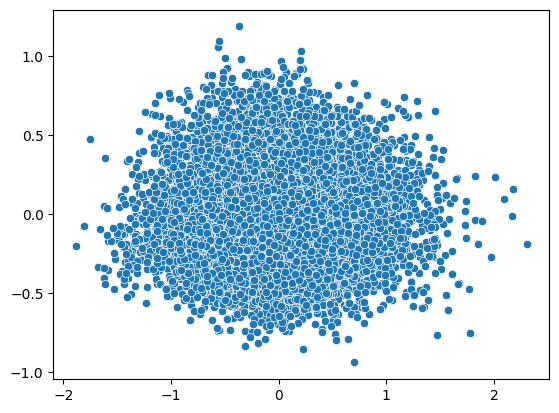

In [35]:
# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1])

In [38]:
# Euclidean distances
book_em_weights_euclidean = book_em_weights / np.linalg.norm(book_em_weights, axis=1).reshape((-1, 1))
np.sum(np.square(book_em_weights[0]))

0.0042604594

<Axes: >

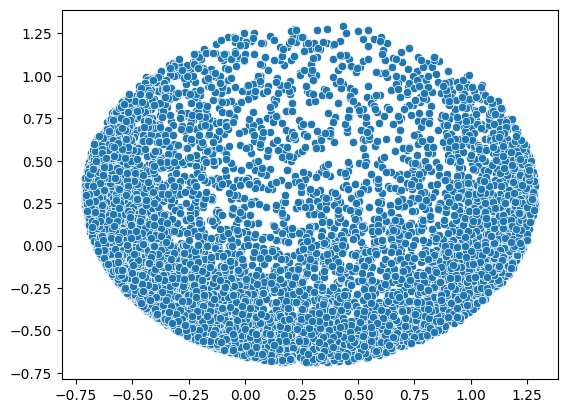

In [39]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(book_em_weights_euclidean)
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1])

In [41]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=250, verbose=True)
tsne_results = tsne.fit_transform(book_em_weights_euclidean)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.023s...
[t-SNE] Computed neighbors for 10001 samples in 0.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.109935
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.894287
[t-SNE] KL

<Axes: >

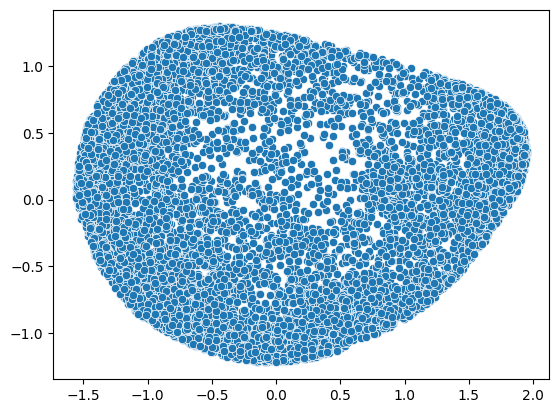

In [42]:
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])

## Making recommendations

In [43]:
book_data = np.array(list(set(ratings_df.book_id)))

In [67]:
user_id = 523
user = np.array([user_id for _ in range(len(book_data))])

In [68]:
user_predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in user_predictions])
recommended_book_ids = (-predictions).argsort()[:10]

313/313 [==============================] - 0s 872us/step


In [69]:
# Print recommended book ids
recommended_book_ids

array([7946, 6589, 8945, 7253, 6919, 8853, 6360, 5579, 9565, 9075])

In [70]:
# Predicted scores
predictions[recommended_book_ids]

array([4.792118 , 4.761044 , 4.7530465, 4.735841 , 4.721219 , 4.7180243,
       4.7001057, 4.6803966, 4.6709614, 4.6564264], dtype=float32)

In [72]:
# Print the recommended books
books_df[books_df.index.isin(recommended_book_ids)]

,authors,year,title,average_rating,num_ratings,num_1,num_2,num_3,num_4,num_5,genres,language,pages
book_id,,,,,,,,,,,,,
5579,Sophie Jordan,2011.0,Vanish,3.95,25947,476,1645,6345,9236,9818,"['fiction', 'thriller', 'mystery', 'suspense',...",eng,385.0
6360,Elin Hilderbrand,2003.0,Summer People,3.93,14369,126,649,4124,6239,4654,"['fantasy', 'fiction', 'young-adult']",eng,368.0
6589,Clive Cussler,1974.0,Iceberg,3.83,16195,141,863,5131,6881,4341,"['poetry', 'classics', 'fiction', 'fantasy']",eng,101.0
6919,George Carlin,2001.0,Napalm & Silly Putty,4.12,12798,141,465,2561,4724,5546,"['biography', 'nonfiction', 'history', 'scienc...",eng,47.0
7253,Stephen R. Donaldson,1982.0,The One Tree,3.96,13812,247,786,3444,5739,5118,"['poetry', 'classics', 'fantasy', 'fiction']",eng,40.0
7946,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...,3.89,13037,234,790,3493,5552,4197,"['young-adult', 'fiction', 'science-fiction']",eng,243.0
8853,John Sandford,1996.0,Sudden Prey,4.15,12408,46,209,2298,6279,4965,"['fiction', 'chick-lit', 'contemporary', 'roma...",eng,304.0
8945,Lisa Gardner,2001.0,The Next Accident,4.16,11261,49,231,2323,5612,5113,"['graphic-novels', 'fantasy', 'fiction', 'myst...",eng,190.0
9075,Jessica Day George,2010.0,Princess of Glass,4.03,17052,145,694,3966,6525,6399,"['fiction', 'fantasy', 'young-adult', 'classic...",es,175.0


## Evaluate the model using precision and recall at K

In [29]:
from tqdm import tqdm
import random

user_ids = train_ratings_df['user_id'].unique() # Train contains all users ids
random.seed(42)
sample_user_ids = random.sample(list(user_ids), 500)
k = 200

In [42]:
def get_top_recommendation_for_user(user_id, all_books, model, k=10):
    user_rated_books = set(train_ratings_df[train_ratings_df['user_id'] == user_id]['book_id'])
    books_not_yet_rated = list(set(all_books) - user_rated_books)

    user_vector = np.array([user_id for _ in range(len(all_books))])   
    user_predictions = model.predict([user_vector, all_books], verbose=0)
    predictions = np.array([a[0] for a in user_predictions])
    recommended_book_ids = (-predictions).argsort()[:k]
    return recommended_book_ids

all_book_ids = np.array(ratings_df.book_id.unique())
recommendations = {}
for user_id in tqdm(sample_user_ids, desc="Getting recommendations for users"):
    top_n_recommendations = get_top_recommendation_for_user(user_id, all_book_ids, model, k=k)
    recommendations[user_id] = top_n_recommendations

Getting recommendations for users: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


In [43]:
def precision_recall_at_k(user_id, top_n_recommendations, k= 100):
    relevant_items  = set(test_ratings_df[(test_ratings_df.user_id == user_id) & (test_ratings_df.rating>=3)]['book_id'])
    if len (relevant_items ) == 0: return -1, -1 # Can not evaluate this user if no relavant items in test set
    true_positives = len(relevant_items.intersection(set(top_n_recommendations[:k])))

    false_positives = len(top_n_recommendations) - true_positives
    false_negatives = len(relevant_items) - true_positives

    tp, fp, fn = true_positives, false_positives, false_negatives

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

In [57]:
k = 200

total_precision = 0
total_recall = 0
count = len(user_ids)

for user_id in tqdm(sample_user_ids, desc="Evaluating recommendations"):
    top_n_recommendations = recommendations[user_id]
    precision, recall = precision_recall_at_k(user_id, top_n_recommendations, k)

    if precision > 0:
        total_precision += precision
        total_recall += recall
    elif precision < 0: # There were no relavant items
        count -=1

average_precision = total_precision / count
average_recall = total_recall / count

print(f"Precision@{k}: {average_precision:.8f}")
print(f"Recall@{k}: {average_recall:.8f}")

Evaluating recommendations: 100%|██████████| 500/500 [00:00<00:00, 593.19it/s]

Precision@200: 0.00000543
Recall@200: 0.00017611
